In [133]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns

import soccer_webScraping as soccerLoader

# Problem Statement: How does attendance influence winning at home games?

Inspired by a podcast that suggested home field advantage is only due to crowd influence on the referees, I decided to investigate this relationship with soccer data pre-pandemic, and during-pandemic. 

## Simplification of problem statement: Did the rate of home-wins change during pandemic era games as opposed to pre-pandemic? 

Future evolutions of the question:

1) Does the rate of home wins change once VAR (video-assisted review) was implemented?


In [2]:
try:
    df = pd.read_csv('soccer_results.csv')
except:  
    df = soccerLoader.collect_all_matches()

I also noticed that for certain websites, I load 2 per each type. I'm not sure why, the websites definitely show 2 but only 1 entry in the  table. Simplest solution is just to drop duplicates>

In [3]:
df.drop(df[df['HomeTeam'].isna()].index,axis=0,inplace=True)
df.drop_duplicates(inplace = True)
df.sample(5)

,SeasonYear,Country,HomeTeam,HomeGoals,AwayTeam,AwayGoals,Attendance
1016,2016,England,Tottenham,4,Stoke City,0,"31,864"
4785,2019,Spain,Espanyol,1,Mallorca,0,"32,084"
14113,2015,Italy,Inter,1,Atalanta,0,"37,042"
148,2014,England,Aston Villa,2,Leicester City,1,"27,692"
6124,2015,Germany,Augsburg,1,Bayern Munich,3,"30,660"


In [4]:
df['Attendance'] = df['Attendance'].str.replace(',','').fillna(0).astype(np.int64)

# Verification of Web Scrapping

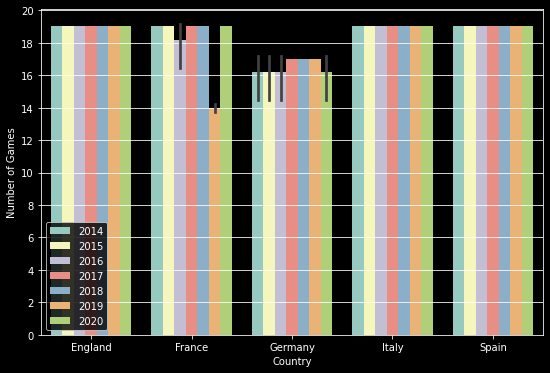

In [5]:
group_data = df.groupby(['SeasonYear','Country','HomeTeam']).count().reset_index()

_,ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x = 'Country',y = 'AwayTeam', hue = 'SeasonYear' , data = group_data,ax = ax);
ax.legend(loc = 'best'); 
ax.set_ylabel('Number of Games');

ax.set_yticks(range(0,22,2))
ax.set_yticklabels(range(0,22,2))
ax.grid(True,which='major',axis='y');

Looks like Germany 2018,2019, and 2020 and France 2016 need to be explored more in depth. Seasons should have all the same amount of games. France 2019 is weird, but maybe the season was just cut short due to COVID.

* Solved the issue with Germany. I was reading the Austrian Bundesliga, but now it's been fixed.
* Solved the issue with 34 home games. Website has 2 entries per game in the html (not in table?). Simply dropped duplicates.

* France 2016 and Germany 2014,2015,2016, 2020 have the variability due to the relegation play off
    

* France 2019 is shorter, due to the cancellation b/c of COVID.

I noticed that there are 6 rows that have NaNs for the team ids. After investigating, these arise from the Relegation playoffs for Ligue 1, and since they are not part of the regular season I will just drop them.

In [6]:
def drop_relegation_match(df,country,year):
    """Function used to identify and drop the matches for relegation/promotion

    Args:
        df (dataFrame): dataframe with the match results 
        country (string): country to identify the relegation/promotion 
        year (int): year to identify the relegation/promotion

    Returns:
        dataFrame : dataframe with the relegation/promotion matches removed, if any
    """
    #Determine the total matches played by all teams in this season/country. Sorted by least payed to most
    team_matches = df[(df['Country'] == country) & (df['SeasonYear'] == year)].groupby('AwayTeam').count()['HomeTeam'].sort_values().reset_index().rename({'HomeTeam':'GamesPlayed','AwayTeam':'Team'},axis=1)
    tmp_df = df[(df['Country'] == country) & (df['SeasonYear'] == year)].groupby('HomeTeam').count()['AwayTeam'].sort_values().reset_index().rename({'AwayTeam':'GamesPlayed','HomeTeam':'Team'},axis=1)
    team_matches['GamesPlayed'] = team_matches['GamesPlayed'] + tmp_df['GamesPlayed']
    
    #if the least number of matches played is less than 3 standard deviations from the mean, then we will drop the team
    if team_matches.loc[0]['GamesPlayed'] < (team_matches['GamesPlayed'].mean() - 3*team_matches['GamesPlayed'].std()):
        drop_team = team_matches.loc[0]['Team']
        #find the index for both the home and away match and drop them but only for this season/year
        drop_indx = df[((df['HomeTeam'] == drop_team) | (df['AwayTeam'] == drop_team)) & 
                       (df['SeasonYear'] == year) & (df['Country'] == country)].index
        df.drop(drop_indx,axis=0,inplace = True)
    
    return df
    

Drop the relegation/promotion matches.

In [7]:
for yr in [2014,2015,2016,2017,2020]:
    df = drop_relegation_match(df,'Germany',yr)
    
for yr in [2016,2019]:    
    df = drop_relegation_match(df,'France',yr) 

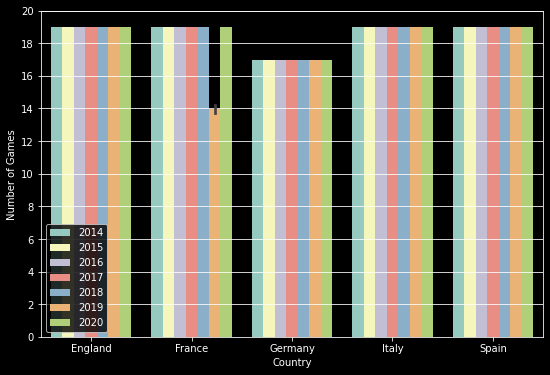

In [8]:
group_data = df.groupby(['SeasonYear','Country','HomeTeam']).count().reset_index()

_,ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x = 'Country',y = 'AwayTeam', hue = 'SeasonYear' , data = group_data,ax = ax);
ax.legend(loc = 'best'); 
ax.set_ylabel('Number of Games');

ax.set_yticks(range(0,22,2))
ax.set_yticklabels(range(0,22,2))
ax.grid(True,which='major',axis='y');

We now see that there is no variability in games(apart from the COVID season in France). Let's check the away matches to makes sure we are good.

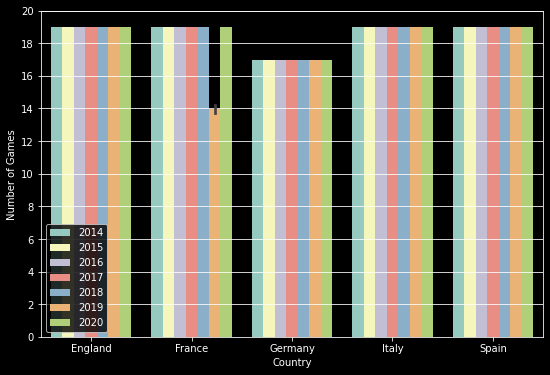

In [9]:
group_data = df.groupby(['SeasonYear','Country','AwayTeam']).count().reset_index()

_,ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x = 'Country',y = 'HomeTeam', hue = 'SeasonYear' , data = group_data,ax = ax);
ax.legend(loc = 'best'); 
ax.set_ylabel('Number of Games');

ax.set_yticks(range(0,22,2))
ax.set_yticklabels(range(0,22,2))
ax.grid(True,which='major',axis='y');

# Exploratory Data Analysis

## Soccer Matches, Wins, Losses

Alright, so now I feel good about the data that I've collected. Ready to start performing some EDA statistics about attendance, and home and away wins. 

### Begin by creating new columns describing if a home win, loss, or tie.

In [10]:
df['HomeWin']= df.apply(lambda row: row['HomeGoals'] > row['AwayGoals'],axis=1);
df['HomeLoss']= df.apply(lambda row: row['HomeGoals'] < row['AwayGoals'],axis=1);
df['Tie']= df.apply(lambda row: row['HomeGoals'] == row['AwayGoals'],axis=1);

### Generate DataFrame showing total wins / total points

In [11]:
tmp_df1 = df.groupby(['SeasonYear','Country','HomeTeam']).sum()[['HomeWin','Tie']].reset_index().rename({'HomeTeam':'Team'},axis=1)
tmp_df2 = df.groupby(['SeasonYear','Country','AwayTeam']).sum()[['HomeLoss','Tie']].reset_index().rename({'AwayTeam':'Team','HomeLoss':'AwayWin'},axis=1)

team_table = pd.merge(tmp_df1,tmp_df2[['SeasonYear','Country','Team','AwayWin']],on=['SeasonYear','Country','Team'])
team_table['Tie'] = team_table['Tie'].add(tmp_df2['Tie'])

team_table['Points'] = team_table.apply(lambda x : x['HomeWin']*3 + x['Tie'] + x['AwayWin']*3,axis=1)

Append the total number of games that each team/year played

In [12]:
def find_tot_teams(row):
    return len(df[((df['HomeTeam'] == row['Team']) | (df['AwayTeam'] == row['Team'])) & (df['SeasonYear'] == row['SeasonYear'])])    

team_table['TotGames'] = team_table.apply(find_tot_teams,axis=1)

### Filter teams that did not play all seasons

In [13]:
def filter_all_season_teams(df,team_table):

    valid_teams = df.pivot_table(index = 'SeasonYear',columns = 'HomeTeam',values = 'HomeWin', aggfunc=np.sum).dropna(axis=1).columns.values
    invalid_teams = list(set(df.HomeTeam.unique()) - set(valid_teams))

    print('Number of teams dropped: ' + str(len(invalid_teams)))

    df = df[(~df['HomeTeam'].isin(invalid_teams)) & (~df['AwayTeam'].isin(invalid_teams))]
    team_table = team_table[team_table['Team'].isin(valid_teams)]
    return df,team_table    

df,team_table = filter_all_season_teams(df,team_table)

Number of teams dropped: 89


In [14]:
team_table[(team_table['SeasonYear']==2018) & (team_table['Country'] == 'England')].sort_values('Points',ascending=False)

,SeasonYear,Country,Team,HomeWin,Tie,AwayWin,Points,TotGames
404,2018,England,Manchester City,18,2,14,98,38
403,2018,England,Liverpool,17,7,13,97,38
397,2018,England,Chelsea,12,9,9,72,38
408,2018,England,Tottenham,12,2,11,71,38
392,2018,England,Arsenal,14,7,7,70,38
405,2018,England,Manchester Utd,10,9,9,66,38
399,2018,England,Everton,10,9,5,54,38
402,2018,England,Leicester City,8,7,7,52,38
410,2018,England,West Ham,9,7,6,52,38
398,2018,England,Crystal Palace,5,7,9,49,38


Example of the team graph. I've checked a few seasons with the online data and we match.

In [15]:
df.sample(15)

,SeasonYear,Country,HomeTeam,HomeGoals,AwayTeam,AwayGoals,Attendance,HomeWin,HomeLoss,Tie
10003,2014,France,Bordeaux,2,Montpellier,1,40275,True,False,False
15844,2019,Italy,Udinese,0,Inter,2,23215,False,True,False
10714,2016,France,Rennes,2,Lille,0,24056,True,False,False
15159,2017,Italy,Juventus,3,Milan,1,41156,True,False,False
14327,2015,Italy,Sassuolo,0,Roma,2,11102,False,True,False
13759,2014,Italy,Inter,2,Atalanta,0,29535,True,False,False
5502,2014,Germany,Werder Bremen,3,Augsburg,2,39746,True,False,False
15715,2019,Italy,Fiorentina,1,Lazio,2,33281,False,True,False
12186,2018,France,Marseille,2,Saint-Étienne,0,57337,True,False,False
11412,2017,France,Nice,1,Nantes,1,20966,False,False,True


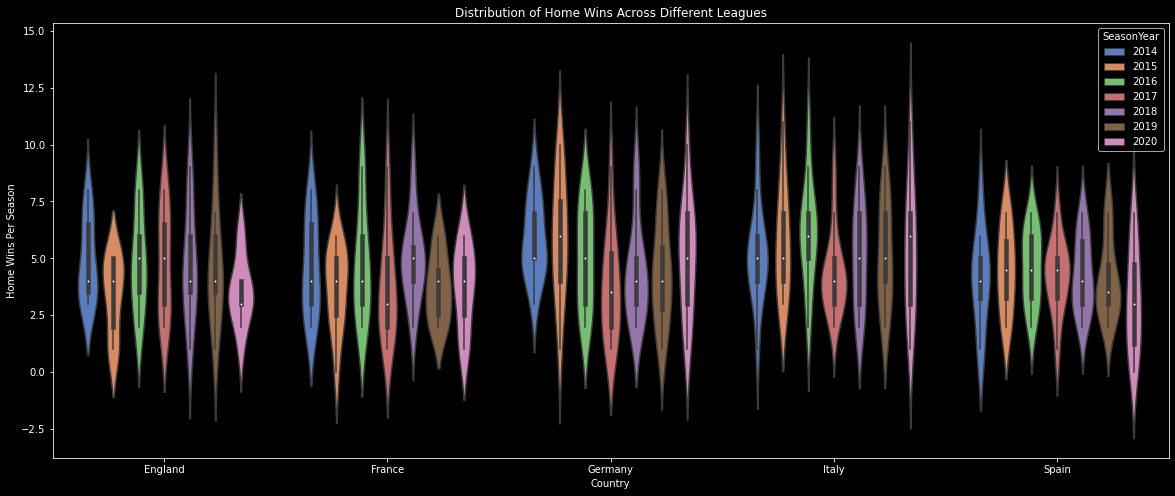

In [16]:
group_df = df.groupby(['SeasonYear','Country','HomeTeam']).sum()['HomeWin'].reset_index()
_,ax = plt.subplots(figsize=(20,8))
ax = sns.violinplot(x='Country', y='HomeWin', hue='SeasonYear',data=group_df, palette="muted",ax=ax)

ax.set_ylabel('Home Wins Per Season');
ax.set_title('Distribution of Home Wins Across Different Leagues');

From the above graph, it appears that the general average of home wins, per league, remains fairly constant across all years currently observed.

In [17]:
group_df = team_table.groupby(['Country','Team']).sum().reset_index().sort_values(by='Points')
country = group_df.Country.unique()

all_best,all_worst = [],[]
tot_obs = 10

for c in country:
    best_teams = group_df[group_df['Country'] == c].sort_values(by='Points',ascending=False).head(tot_obs//2)['Team'].values
    worst_teams = group_df[group_df['Country'] == c].sort_values(by='Points').head(tot_obs//2)['Team'].values

    all_best.extend(best_teams)
    all_worst.extend(worst_teams)

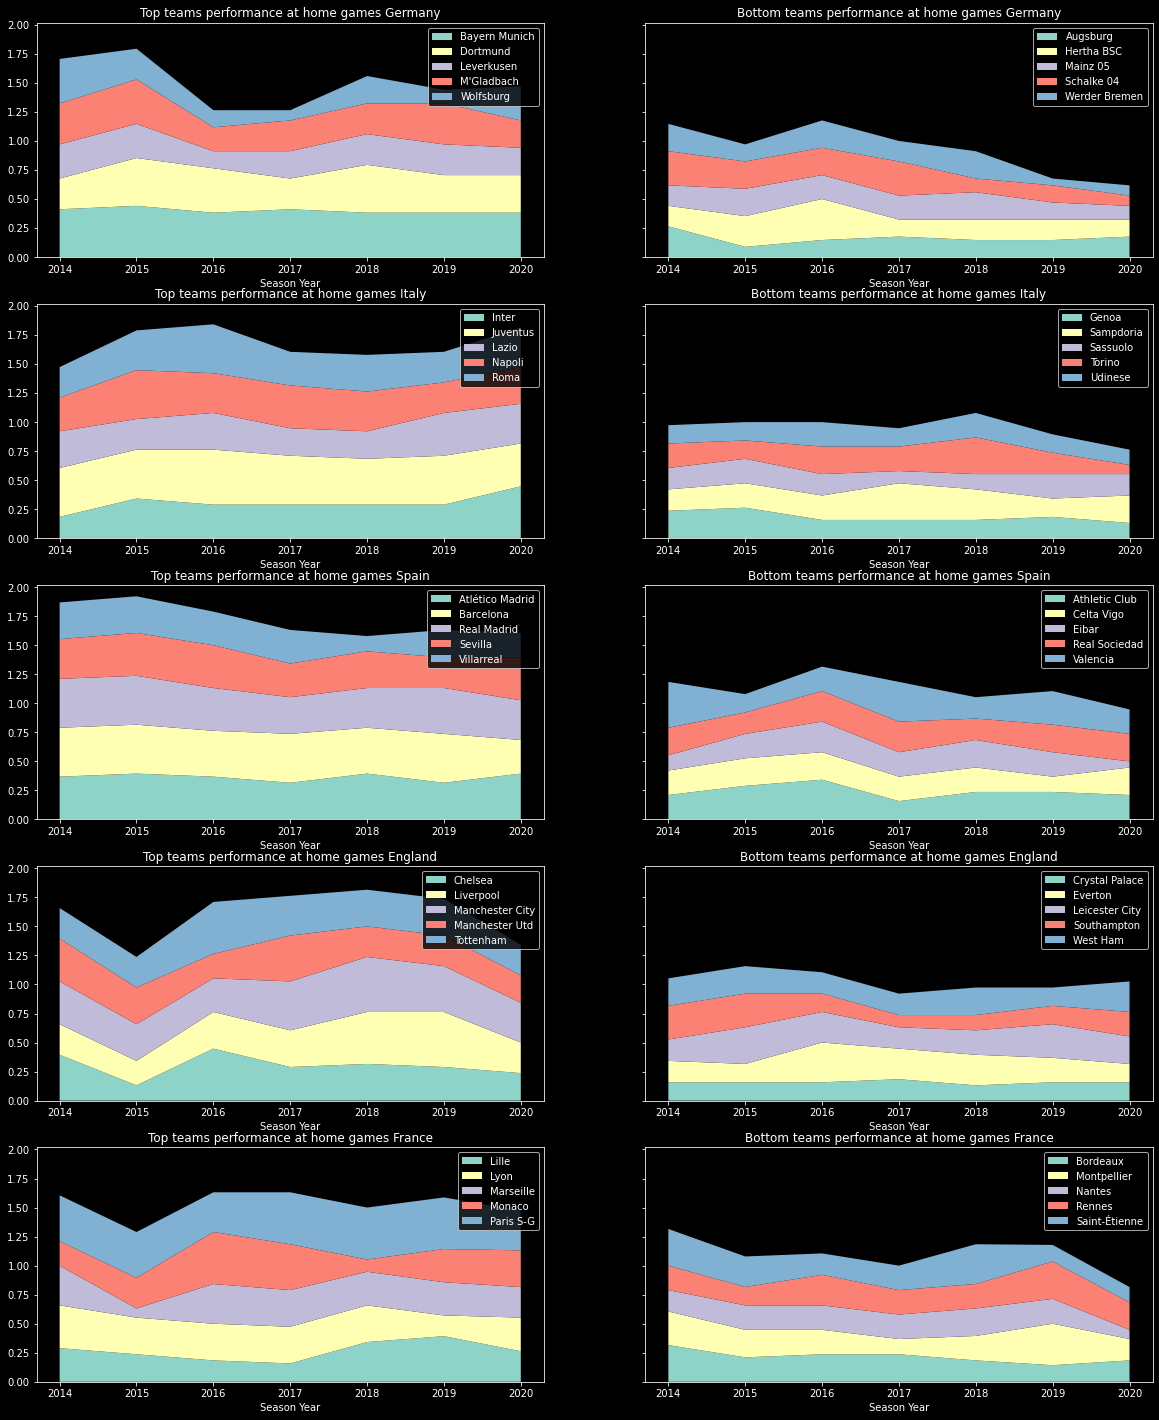

In [18]:
_,ax = plt.subplots(ncols =2 ,nrows = len(country), figsize = (20,25),sharey=True);

best_df = team_table[team_table['Team'].isin(all_best)].copy()
best_df['HomeWin']= best_df['HomeWin'].divide(best_df['TotGames'])
group_best = best_df.pivot(index='SeasonYear',columns = ['Country','Team'],values = 'HomeWin')

worst_df = team_table[team_table['Team'].isin(all_worst)].copy()
worst_df['HomeWin']= worst_df['HomeWin'].divide(worst_df['TotGames'])
group_worst = worst_df.pivot(index='SeasonYear',columns = ['Country','Team'],values = 'HomeWin')


for i,c in enumerate(country):

    ax[i][0].stackplot(group_best.index.values,group_best[c].values.T);
    ax[i][1].stackplot(group_worst.index.values,group_worst[c].values.T);
    
    ax[i][0].set_title(f'Top teams performance at home games {c}');
    ax[i][0].set_xlabel('Season Year');
    ax[i][0].legend(group_best[c].columns.values)
    
    ax[i][1].set_title(f'Bottom teams performance at home games {c}');
    ax[i][1].set_xlabel('Season Year');
    ax[i][1].legend(group_worst[c].columns.values)


Realy interesting figure above. If instead of looking at all teams we focus on the best performing and worst perfoming, it appears that in general the worst performing teams had worst performance in 2019/2020 while the best performing remain fairly constant. 

Since 2019/2020 is when the pandemic effects took off, perhaps this hints that at a league level we won't see much varability, but the variability will be seen at the team level.

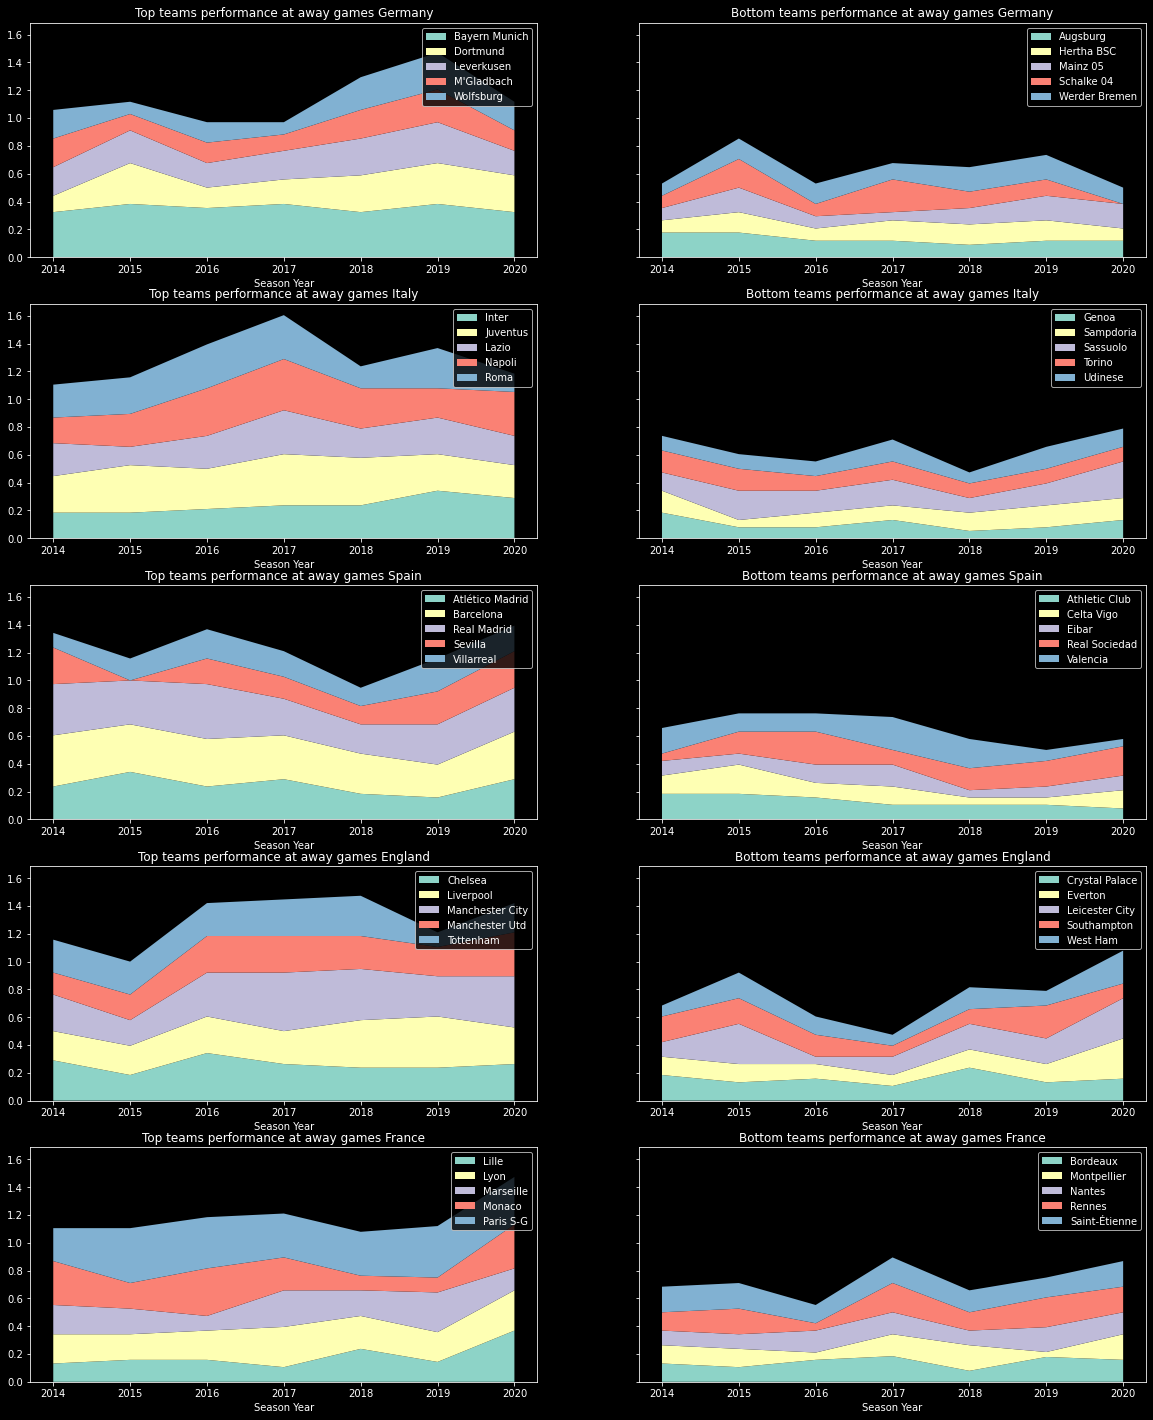

In [19]:
_,ax = plt.subplots(ncols =2 ,nrows = len(country), figsize = (20,25),sharey=True);

best_df = team_table[team_table['Team'].isin(all_best)].copy()
best_df['AwayWin']= best_df['AwayWin'].divide(best_df['TotGames'])
group_best = best_df.pivot(index='SeasonYear',columns = ['Country','Team'],values = 'AwayWin')

worst_df = team_table[team_table['Team'].isin(all_worst)].copy()
worst_df['AwayWin']= worst_df['AwayWin'].divide(worst_df['TotGames'])
group_worst = worst_df.pivot(index='SeasonYear',columns = ['Country','Team'],values = 'AwayWin')


for i,c in enumerate(country):

    ax[i][0].stackplot(group_best.index.values,group_best[c].values.T);
    ax[i][1].stackplot(group_worst.index.values,group_worst[c].values.T);
    
    ax[i][0].set_title(f'Top teams performance at away games {c}');
    ax[i][0].set_xlabel('Season Year');
    ax[i][0].legend(group_best[c].columns.values)
    
    ax[i][1].set_title(f'Bottom teams performance at away games {c}');
    ax[i][1].set_xlabel('Season Year');
    ax[i][1].legend(group_worst[c].columns.values)



## Attendance

We need to account for differing stadium sizes. Ideally, we could identify the stadium capacity, but that is probably a bit hard considering how many teams we have. Twop options that come to mind:

1) Normalize by the average attendance : the obvious one, but I think it might wrong. 


2) Normalize by the maximum attendance : probably more representative to "maximum capacity"

In [129]:
## This is the equation to change depending on how we want to determine each season attendance
def find_season_attendance(row):
    max_atten = df[(df['HomeTeam'] == row['Team']) & (df['SeasonYear'] == row['SeasonYear'])]['Attendance'].max()
    return max_atten

team_table['MaxAttendance'] = team_table.apply(find_season_attendance,axis=1)

In [170]:
## Normalize each match's attendance 
def normalize_season_attendance(row):
    max_atten = team_table[(team_table['Team']  == row['HomeTeam']) & (team_table['SeasonYear'] == row['SeasonYear'])]['MaxAttendance']
    if max_atten.item() == 0:
        return 0
    return (row['Attendance'] / max_atten).item()

df['NormalizedAttendance'] = df.apply(normalize_season_attendance,axis=1)

In [171]:
df.sample(5)

,SeasonYear,Country,HomeTeam,HomeGoals,AwayTeam,AwayGoals,Attendance,HomeWin,HomeLoss,Tie,NormalizedAttendance
1017,2016,England,Leicester City,3,Liverpool,1,32034,True,False,False,0.998815
5954,2015,Germany,Wolfsburg,3,Schalke 04,0,30000,True,False,False,1.000000
5960,2015,Germany,Bayern Munich,3,Leverkusen,0,75000,True,False,False,1.000000
12894,2019,France,Rennes,3,Nantes,2,27836,True,False,False,0.963317
10291,2015,France,Paris S-G,0,Montpellier,0,45173,False,False,True,0.944173


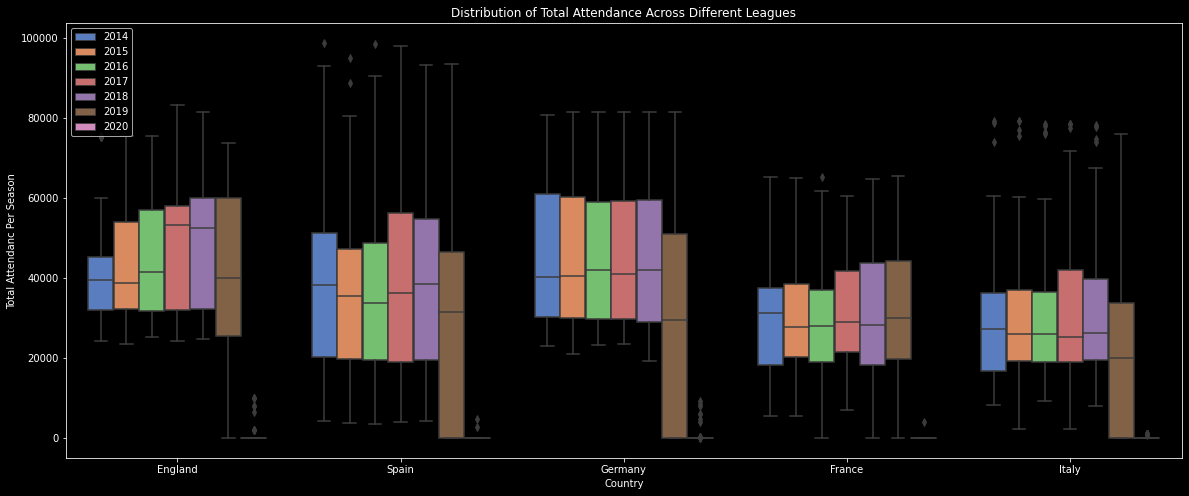

In [213]:
_,ax = plt.subplots(figsize=(20,8))
ax = sns.boxplot(x='Country', y='Attendance', hue='SeasonYear',data=df, palette="muted",ax=ax)

ax.set_ylabel('Total Attendanc Per Season');
ax.set_title('Distribution of Total Attendance Across Different Leagues');
ax.legend(loc='best')

Interesting behavior regarding the mean attendance at games.

 For England, in 2017 mean attendance drastically increased, dropping in 2019.

 For Spain and Germany, attendance remained relatively constanct, except for 2019, where it dropped, explained since COVID hit in half way through the season. Similar behaivor for Italy but not as intense.

 For France, attendance remained relatively constant, but primarily because games did not resume after COVID in 2019-2020, but rather completely shut down.


The least attended leagues are the French and Italy leagues. While English, Spanish, and German have similar averages. 



In [113]:
def attendance_distribution(df,country,year,teams,axes = [], bins=100):
    all_teams = df[(df['Country'] == country)]['NormalizedAttendance'].values
    w1 = np.ones_like(all_teams) / len(all_teams)
    some_teams = df[(df['Country'] == country) & (df['HomeTeam'].isin(teams))]['NormalizedAttendance'].values
    w2 = np.ones_like(some_teams) / len(some_teams)
    
    if not axes:
        axes = plt.axes()
        
    axes.hist([all_teams,some_teams],bins=bins,weights=[w1,w2],density=False,color = ['yellow','red'])
    plt.legend(['All Teams','Select Teams'])

Want to see if the distributions of attendance are different for top performing teams vs. bottom performing teams. 

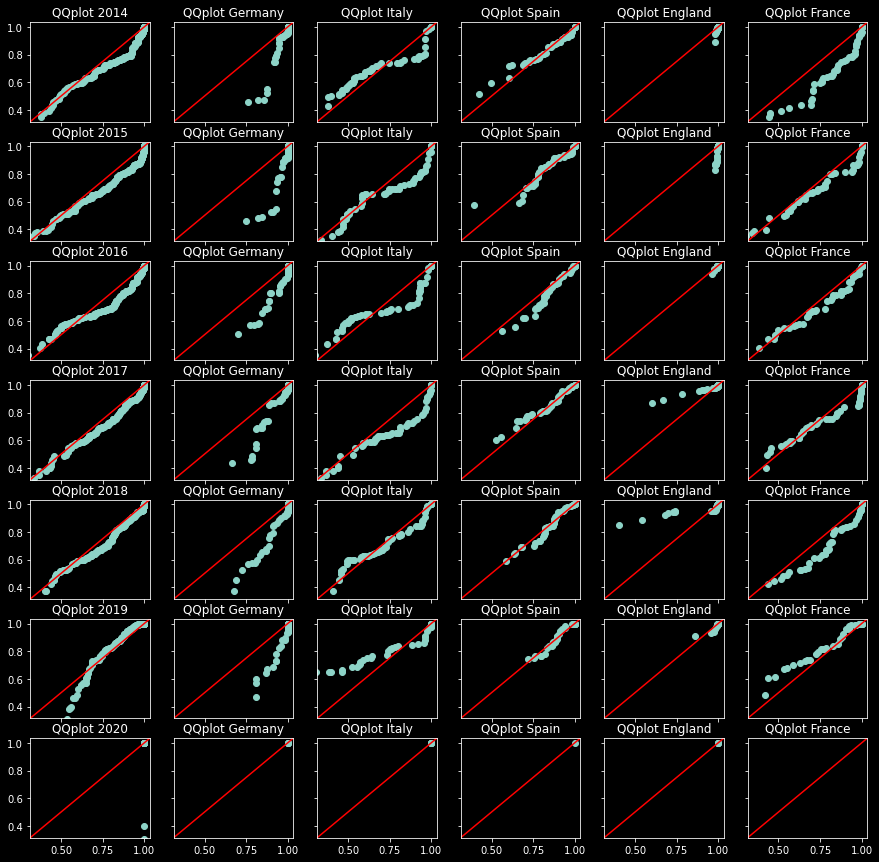

In [208]:
yrs = [2014,2015,2016,2017,2018,2019,2020]
p_vals = []

_,ax = plt.subplots(nrows = len(yrs), ncols = len(country)+1 ,sharex = True, sharey= True, figsize = (15,15))
for i,yr in enumerate(yrs):
    best_teams = df[(df['SeasonYear'] == yr) & (df['HomeTeam'].isin(all_best))]['NormalizedAttendance'].values
    worst_teams = df[(df['SeasonYear'] == yr) & (df['HomeTeam'].isin(all_worst))]['NormalizedAttendance'].values

    sm.qqplot_2samples(best_teams,worst_teams,line='45',ax = ax[i][0])
    ax[i][0].set_title('QQplot ' + str(yr))
    ax[i][0].set_ylabel('')
    ax[i][0].set_xlabel('')
    
    country_ps = [ss.ks_2samp(best_teams,worst_teams).pvalue]
    for k,c in enumerate(country):
        country_best = df[(df['SeasonYear'] == yr) & (df['Country'] ==c) & (df['HomeTeam'].isin(all_best))]['NormalizedAttendance'].values
        country_worst = df[(df['SeasonYear'] == yr) & (df['Country'] ==c) & (df['HomeTeam'].isin(all_worst))]['NormalizedAttendance'].values

        sm.qqplot_2samples(country_best,country_worst,line='45',ax = ax[i][k+1])
        ax[i][k+1].set_title('QQplot ' + c)
        ax[i][k+1].set_ylabel('')
        ax[i][k+1].set_xlabel('')
        
        country_ps.append(ss.ks_2samp(country_best,country_worst).pvalue)
        
    p_vals.append(country_ps)

The above figures show some interesting behaviors. 

1) At the group population level, attendance seems to be fairly similar at top performing vs bottom performing teams.

2) Different leagues have different behaviors. 

** Germany, top performing teams have high levels of attendance while bottom performing teams have a larger spread of attendance. 

** Italy and France, both have similar behaviors in terms of attendance between top performers and bottom performers.

** England, games appear to be frequently heavily attended, regardless of the placement of the  team.
